In [3]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
aisles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/aisles.csv')
departments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/departments.csv')

order_products_prior = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/order_products__prior.csv')

orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/orders.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/products.csv')

In [6]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')


In [7]:
order_products = order_products.merge(aisles, on ='aisle_id', how='left')


In [8]:
order_products = order_products.merge(departments, on ='department_id', how='left')


In [9]:
del aisles, departments, order_products_prior

In [10]:
order_products = order_products.merge(orders, on='order_id', how='left')


In [11]:
del orders, products

In [12]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [13]:
order_products.user_id.nunique()

206209

## Segmentation

Поскольку в наборе данных есть тысячи продуктов, я буду полагаться на проходы, которые представляют категории продуктов. Даже при наличии проходов функций будет слишком много, поэтому я воспользуюсь анализом главных компонентов, чтобы найти новые измерения, по которым будет проще кластеризовать.

In [14]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [15]:
del order_products

Нормализую

In [16]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [17]:
df.shape

(206209, 134)

### PCA and K-Means Clustering

Надо уменьшить фрейм данных до 3х измерений, поскольку KMeans не работает должным образом в более высоком измерении.

In [18]:
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score

In [19]:
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2
0,-0.113443,0.039084,-0.042862
1,-0.036988,0.108884,-0.066405
2,0.064282,0.103962,0.000711
3,-0.093210,0.054093,0.001867
4,0.094629,-0.037051,-0.024952


In [ ]:
del df

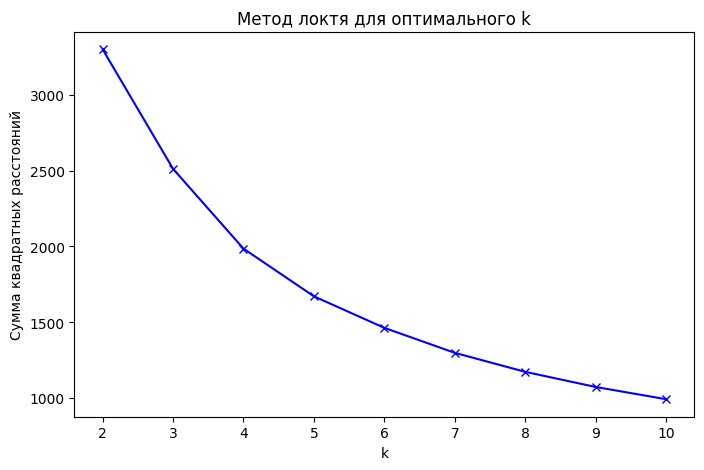

In [ ]:
Sum_of_squared_distances = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Сумма квадратных расстояний')
plt.title('Метод локтя для оптимального k')
plt.show()

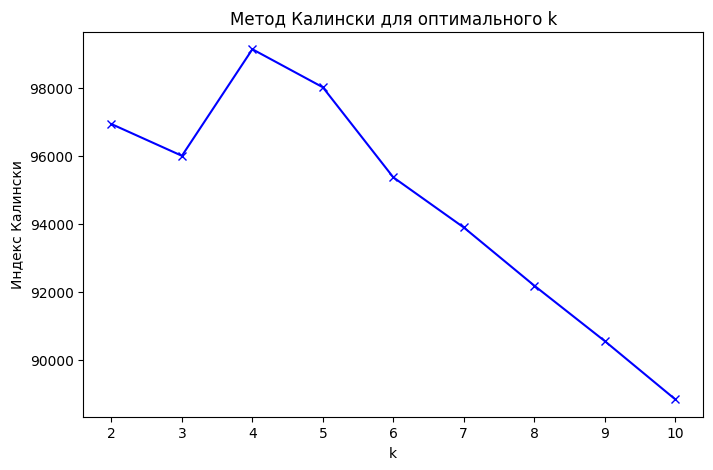

In [ ]:
calinski_harabasz_score_results = []
for k in range(2,11):
    km = KMeans(n_clusters=k)
    km = km.fit_predict(df_pca)

    db_index = calinski_harabasz_score(df_pca, km)
    calinski_harabasz_score_results.append(db_index)


plt.subplots(figsize = (8, 5))
plt.plot(range(2,11), calinski_harabasz_score_results, 'bx-')
plt.xlabel("k")
plt.ylabel("Индекс Калински")
plt.title('Метод Калински для оптимального k')
plt.show()

построю 6 кластеров


In [20]:
clusterer = KMeans(n_clusters=4).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[-0.19351891  0.01701357  0.30563863]
 [-0.07176242 -0.00645778 -0.02714099]
 [ 0.10263215 -0.0639721   0.01573221]
 [ 0.06683283  0.13635855  0.00207943]]


#### Визуализация кластеризации среди первых двух основных компонентов

In [21]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

,pc1,pc2,cluster
0,-0.113443,0.039084,1
1,-0.036988,0.108884,1
2,0.064282,0.103962,3
3,-0.093210,0.054093,1
4,0.094629,-0.037051,2


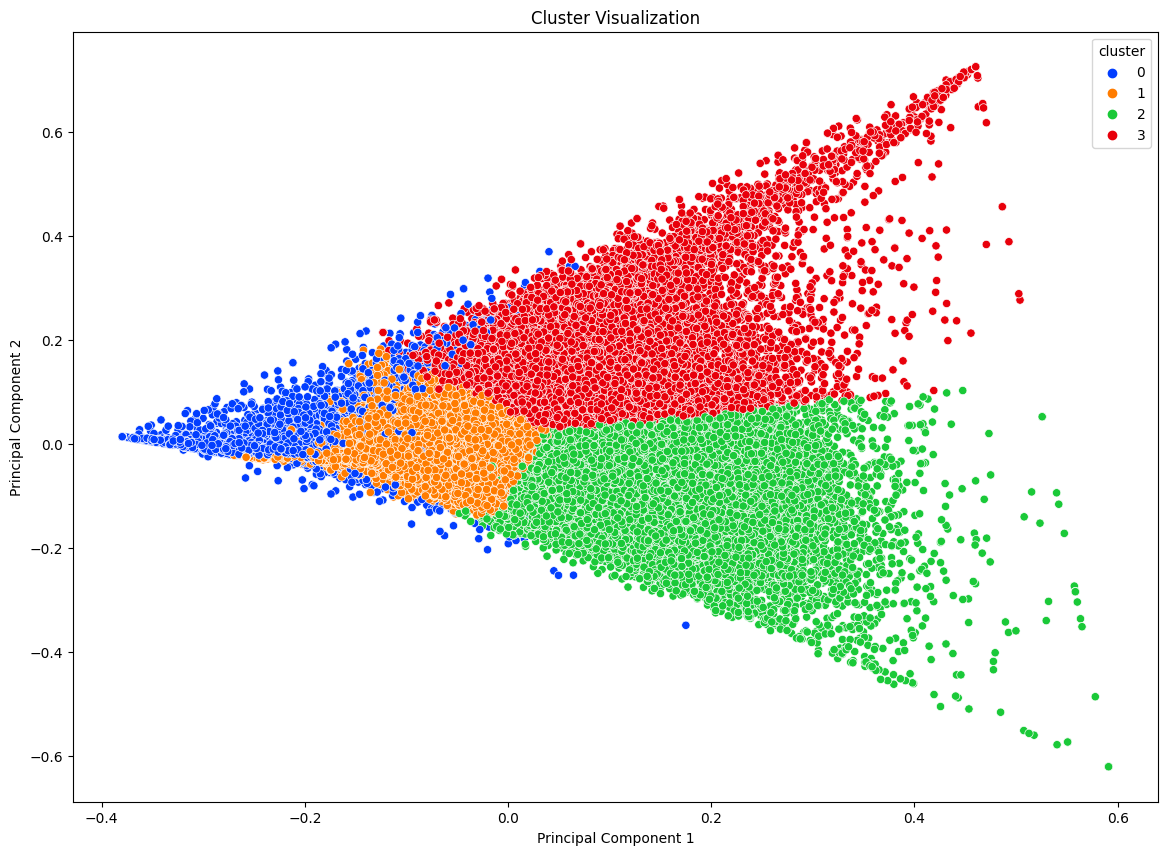

In [22]:
fig, ax = plt.subplots(figsize = (14, 10))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster", palette = 'bright')
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show()

### Лучшие продукты в кластере

In [23]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]


In [24]:
cluster1.shape

(5829, 135)

In [25]:
cluster1.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    117281
fresh fruits                      19342
soft drinks                       16223
yogurt                            10939
energy granola bars                8730
chips pretzels                     7977
tea                                7473
packaged vegetables fruits         7221
milk                               7144
candy chocolate                    6159
dtype: int64

In [26]:
cluster2.shape

(104518, 135)

In [27]:
cluster2.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     1080777
fresh vegetables                  786799
yogurt                            776662
packaged vegetables fruits        644826
packaged cheese                   514999
chips pretzels                    460429
milk                              452604
water seltzer sparkling water     420946
refrigerated                      337412
bread                             317634
dtype: int64

In [28]:
cluster3.shape

(62304, 135)

In [29]:
cluster3.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 2261697
fresh fruits                     1445058
packaged vegetables fruits        775896
yogurt                            408050
packaged cheese                   325278
milk                              265126
fresh herbs                       251391
soy lactosefree                   237669
frozen produce                    210488
water seltzer sparkling water     196434
dtype: int64

In [30]:
cluster4.shape

(33558, 135)

In [31]:
cluster4.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     1097011
fresh vegetables                  363646
packaged vegetables fruits        337370
yogurt                            256692
milk                              166141
packaged produce                  142393
packaged cheese                   134588
water seltzer sparkling water     106872
soy lactosefree                   101960
chips pretzels                     87998
dtype: int64